In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv', low_memory=False, encoding='latin1')

In [3]:
train.shape

(2995, 29)

In [4]:
train.head(1).transpose()

,0
ID,12555
Text,Centers of Biomedical Research Excellence (COB...
3.1.1,0
3.1.2,0
3.2.1,0
3.2.2,0
3.3.1,0
3.3.2,0
3.3.3,0
3.3.4,0


# Number of comments in each category

In [5]:
df_train =train.drop(['ID','Text'], axis=1)
counts = []
categories = list(df_train.columns.values)
for i in categories:
    counts.append((i, df_train[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,3.1.1,218
1,3.1.2,96
2,3.2.1,249
3,3.2.2,138
4,3.3.1,371
5,3.3.2,174
6,3.3.3,157
7,3.3.4,53
8,3.3.5,156
9,3.4.1,483


Text(0.5, 0, 'category')

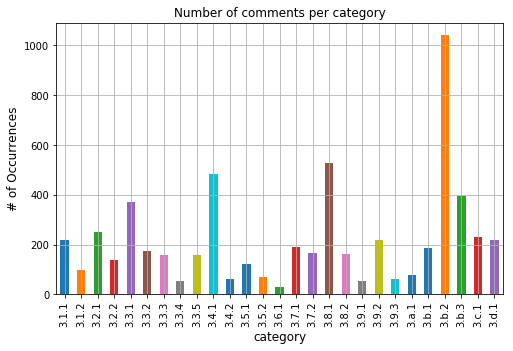

In [6]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## MULTI-LABEL. How many comments have multiple labels?

Text(0.5, 0, '# of categories')

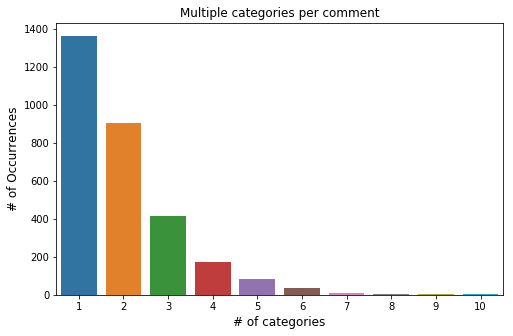

In [7]:
rowsums = train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

# Distribution of the number of comments

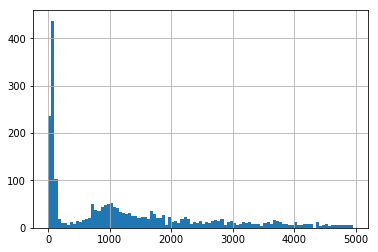

In [8]:
lens = train.Text.str.len()
lens.hist(bins = np.arange(0,5000,50))

In [9]:
print('Percentage of comments that are not labelled:')
print(len(train[(train['3.1.1']==0) & (train['3.1.2']==0) & (train['3.2.1']==0) & (train['3.2.2']== 0) & (train['3.3.1']==0) & (train['3.3.2']==0) & (train['3.3.3']==0) & (train['3.3.4']==0) & (train['3.3.5']==0) & (train['3.4.1']==0) & (train['3.4.2']==0) & (train['3.5.1']==0) & (train['3.5.2']==0) & (train['3.6.1']==0) & (train['3.7.1']==0) & (train['3.7.2']==0) & (train['3.8.1']==0) & (train['3.8.2']==0) & (train['3.9.1']==0) & (train['3.9.2']==0) & (train['3.9.3']==0) & (train['3.a.1']==0) & (train['3.b.1']==0) & (train['3.b.2']==0) & (train['3.b.3']==0) & (train['3.c.1']==0) & (train['3.d.1']==0)]) / len(train))

Percentage of comments that are not labelled:
0.0


In [10]:
print('Number of missing comments in comment text:')
train['Text'].isnull().sum()

Number of missing comments in comment text:


0

In [11]:
#peek the first comment
train['Text'][0]

'Centers of Biomedical Research Excellence (COBRE) Phase III - Transitional Centers     Funding Opportunity Description    The Institutional Development Award (IDeA) Program endeavors to stimulate research at institutions in states that have not traditionally received significant levels of research funding from the NIH. Created through congressional mandate, the IDeA Program broadens the geographic distribution of NIH funding for competitive biomedical and behavioral research by enhancing the research capabilities of institutions in eligible states. The IDeA Program aims to achieve this goal through two major initiatives: (1) the IDeA Networks of Biomedical Research Excellence (INBRE), and (2) the Centers of Biomedical Research Excellence (COBRE).    The COBRE initiative seeks to develop unique, innovative, multidisciplinary, and collaborative state-of-the-art biomedical and behavioral research centers focused on a scientific theme that is nascent or only minimally developed at applica

In [12]:
train.columns.values.tolist()

['ID',
 'Text',
 '3.1.1',
 '3.1.2',
 '3.2.1',
 '3.2.2',
 '3.3.1',
 '3.3.2',
 '3.3.3',
 '3.3.4',
 '3.3.5',
 '3.4.1',
 '3.4.2',
 '3.5.1',
 '3.5.2',
 '3.6.1',
 '3.7.1',
 '3.7.2',
 '3.8.1',
 '3.8.2',
 '3.9.1',
 '3.9.2',
 '3.9.3',
 '3.a.1',
 '3.b.1',
 '3.b.2',
 '3.b.3',
 '3.c.1',
 '3.d.1']